# PREDICTING HEART DISEASE RISK USING CLASSIFICATION MODEL

# Load Data

Load the dataset into a DataFrame

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# imports for handlind imbalance data
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# import for model selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# imports for model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import norm
from sklearn.metrics import classification_report, roc_curve, auc



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Capstone Project/heart_2022_with_nans.csv')
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


# Data Cleaning and Preprocessing

- Check the data types of each column.

- drop unnecessary columns

- Create new features or transform existing ones to improve model performance.

- Identify target column

- Split the data into training and test sets to evaluate model performance

- Visualize and summarize the distributions of numerical and categorical features.

- Detect outliers using visualizations like box plots.

- Check for duplicate rows, inconsistent values, and other data quality issues.

- Convert categorical variables to numerical using encoding techniques like one-hot encoding.

- Normalize or standardize numerical features.

- Impute missing values using appropriate strategies.



In [4]:
# Identify Data Types
print(df.dtypes)

State                         object
Sex                           object
GeneralHealth                 object
PhysicalHealthDays           float64
MentalHealthDays             float64
LastCheckupTime               object
PhysicalActivities            object
SleepHours                   float64
RemovedTeeth                  object
HadHeartAttack                object
HadAngina                     object
HadStroke                     object
HadAsthma                     object
HadSkinCancer                 object
HadCOPD                       object
HadDepressiveDisorder         object
HadKidneyDisease              object
HadArthritis                  object
HadDiabetes                   object
DeafOrHardOfHearing           object
BlindOrVisionDifficulty       object
DifficultyConcentrating       object
DifficultyWalking             object
DifficultyDressingBathing     object
DifficultyErrands             object
SmokerStatus                  object
ECigaretteUsage               object
C

In [5]:
# drop unnecessary columns and create new dataset
df = df.drop(columns=['State', 'RemovedTeeth', 'LastCheckupTime', 'ChestScan', 'HIVTesting','HighRiskLastYear'])

df.columns

Index(['Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays',
       'PhysicalActivities', 'SleepHours', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'CovidPos'],
      dtype='object')

In [6]:
df.shape

(445132, 34)

In [7]:
# Drop missing values for target columns: HadHeartAtack
df.dropna(subset=['HadHeartAttack'], inplace=True)

In [8]:
# Convert the 'HadHeartAttack' column to 1 for patients who have had a heart attack and 0 for those who have not.
df['HadHeartAttack'] = df['HadHeartAttack'].map({'Yes': 1, 'No': 0}).astype(int)

In [9]:
# Edit details in some columns

df['HadDiabetes'].replace({'No, pre-diabetes or borderline diabetes' : 'Borderline',
                            'Yes, but only during pregnancy (female)' : 'During Pregnancy'} , inplace=True)

df['SmokerStatus'].replace({'Never smoked' : 'Never',
                                        'Current smoker - now smokes some days' : 'Somedays',
                                        'Former smoker' : 'Former',
                                        'Current smoker - now smokes every day' : 'Everyday'}, inplace=True)

df['ECigaretteUsage'].replace({'Not at all (right now)' : 'Not at all',
                                        'Never used e-cigarettes in my entire life' : 'Never',
                                        'Use them every day' : 'Everyday',
                                        'Use them some days' : 'Somedays'}, inplace=True)

df['RaceEthnicityCategory'].replace({'White only, Non-Hispanic' : 'White',
                                             'Black only, Non-Hispanic' : 'Black',
                                             'Other race only, Non-Hispanic' : 'Others',
                                             'Multiracial, Non-Hispanic' : 'Multi Racial'}, inplace=True)

df['AgeCategory'].replace({
    'Age 80 or older' : '80+',
    'Age 75 to 79' : '75-79',
    'Age 70 to 74' : '70-74',
    'Age 65 to 69' : '65-69',
    'Age 60 to 64' : '60-64',
    'Age 55 to 59' : '55-59',
    'Age 50 to 54' : '50-54',
    'Age 45 to 49' : '45-49',
    'Age 40 to 44' : '40-44',
    'Age 35 to 39' : '35-39',
    'Age 30 to 34' : '30-34',
    'Age 25 to 29' : '25-29',
    'Age 18 to 24' : '18-24',}, inplace=True)

df['TetanusLast10Tdap'].replace({
    'Yes, received tetanus shot but not sure what type': 'Yes',
    'No, did not receive any tetanus shot in the past 10 years': 'No',
    'Yes, received Tdap': 'Yes',
    'Yes, received tetanus shot, but not Tdap': 'Yes'}, inplace=True)

df['CovidPos'].replace({'Tested positive using home test without a health professional' : 'Yes'}, inplace=True)

for col in df.describe(include='object').columns:
    print('Column Name: ',col)
    print(df[col].unique())
    print('-------------------------------------------------')

Column Name:  Sex
['Female' 'Male']
-------------------------------------------------
Column Name:  GeneralHealth
['Very good' 'Excellent' 'Fair' 'Poor' 'Good' nan]
-------------------------------------------------
Column Name:  PhysicalActivities
['No' 'Yes' nan]
-------------------------------------------------
Column Name:  HadAngina
['No' 'Yes' nan]
-------------------------------------------------
Column Name:  HadStroke
['No' 'Yes' nan]
-------------------------------------------------
Column Name:  HadAsthma
['No' 'Yes' nan]
-------------------------------------------------
Column Name:  HadSkinCancer
['No' 'Yes' nan]
-------------------------------------------------
Column Name:  HadCOPD
['No' 'Yes' nan]
-------------------------------------------------
Column Name:  HadDepressiveDisorder
['No' 'Yes' nan]
-------------------------------------------------
Column Name:  HadKidneyDisease
['No' 'Yes' nan]
-------------------------------------------------
Column Name:  HadArthritis


In [10]:
# Define features and target
X = df.drop(columns=['HadHeartAttack'])
y = df['HadHeartAttack']

In [40]:
# Baseline accuracy
y.value_counts(normalize=True)

HadHeartAttack
0    0.943203
1    0.056797
Name: proportion, dtype: float64

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Examine Distributions
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

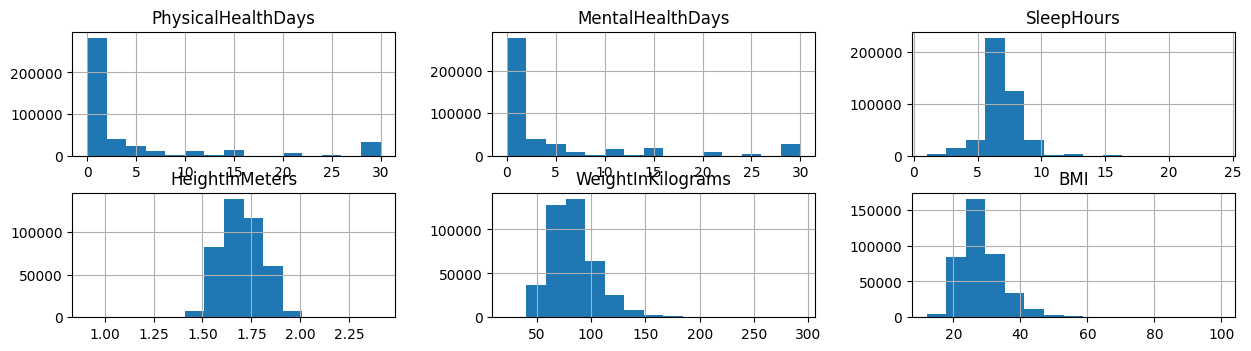

In [13]:
# Plot histograms for numerical features
X[numeric_cols].hist(bins=15, figsize=(15, 10), layout=(5, 3))
plt.show()

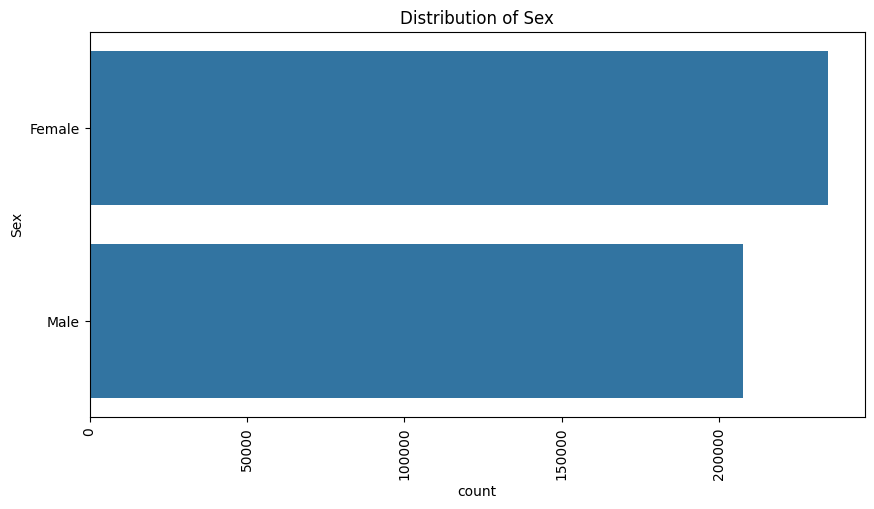

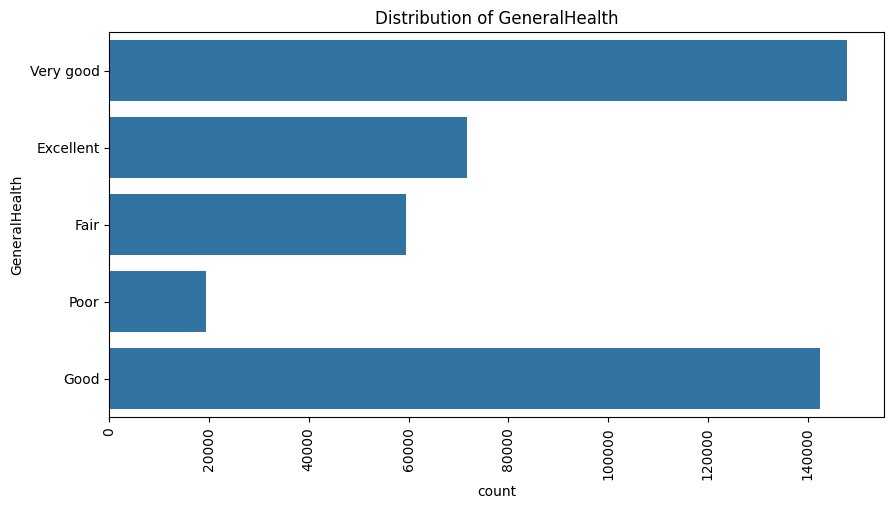

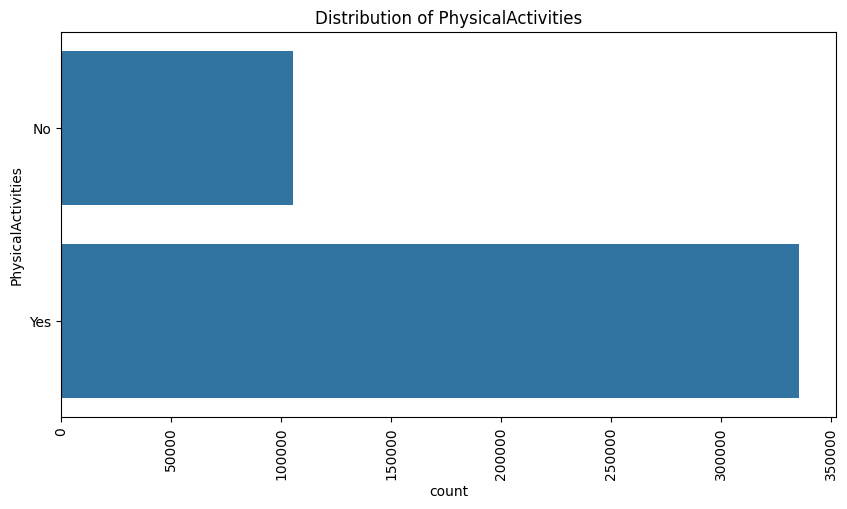

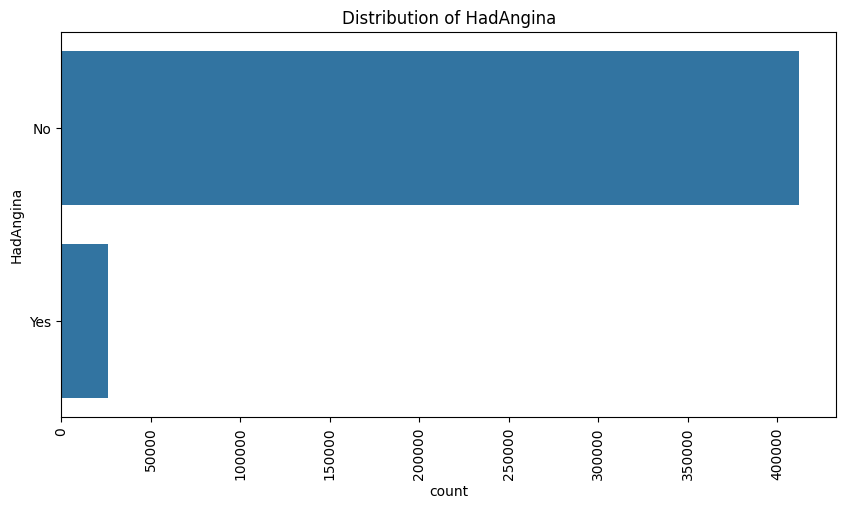

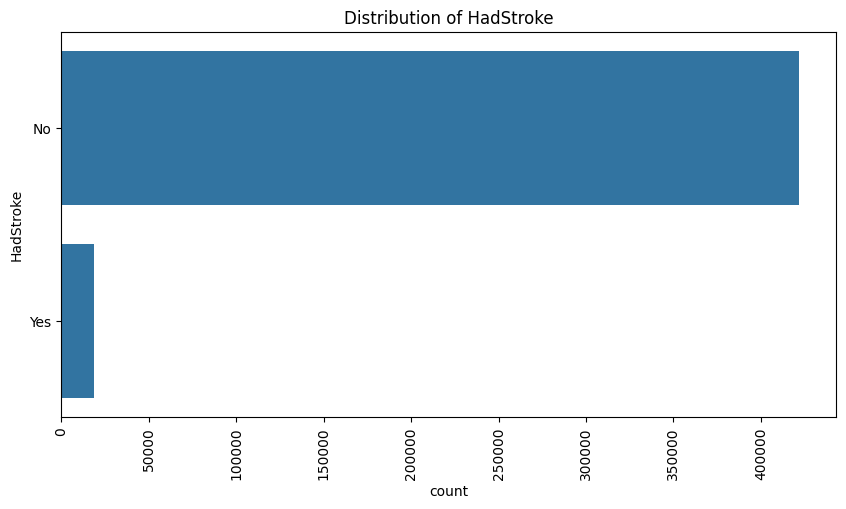

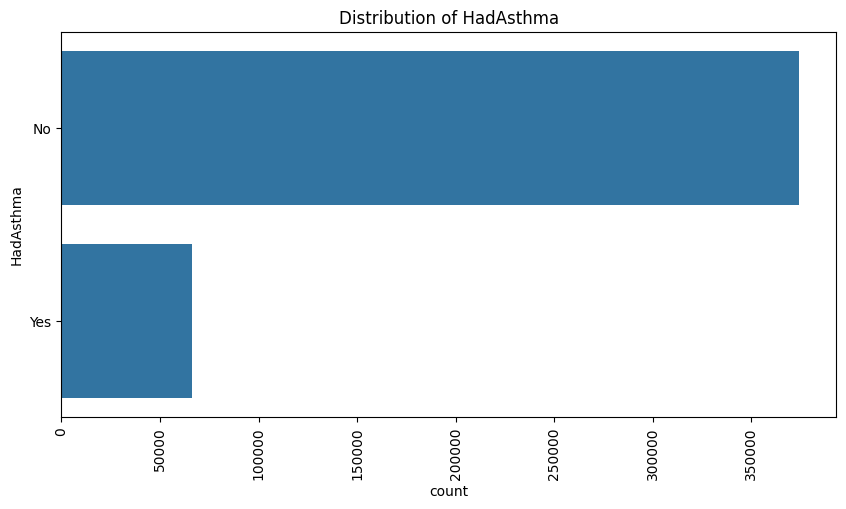

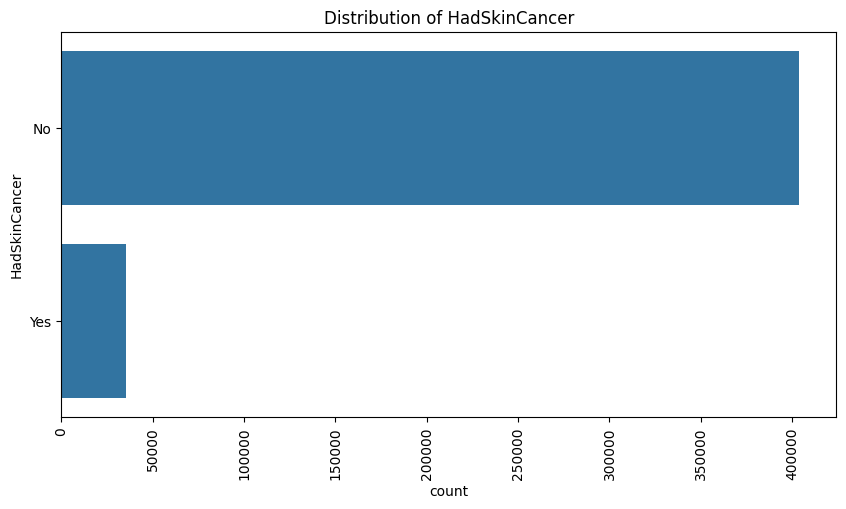

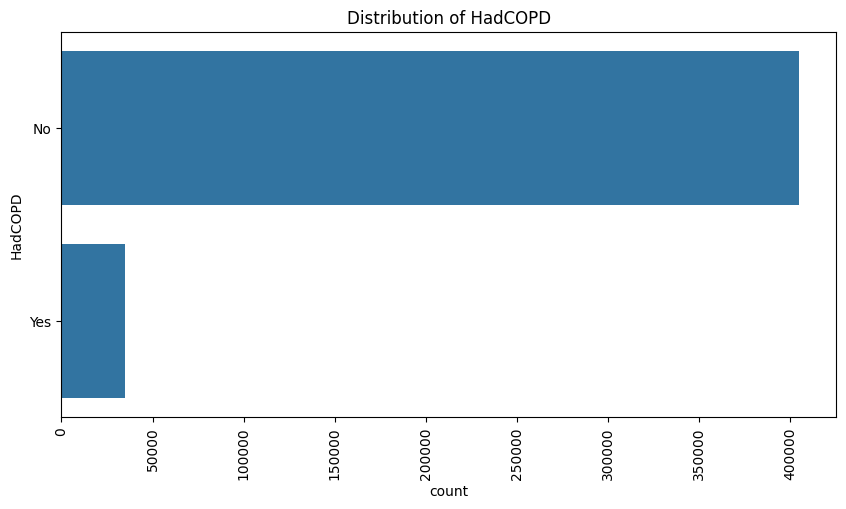

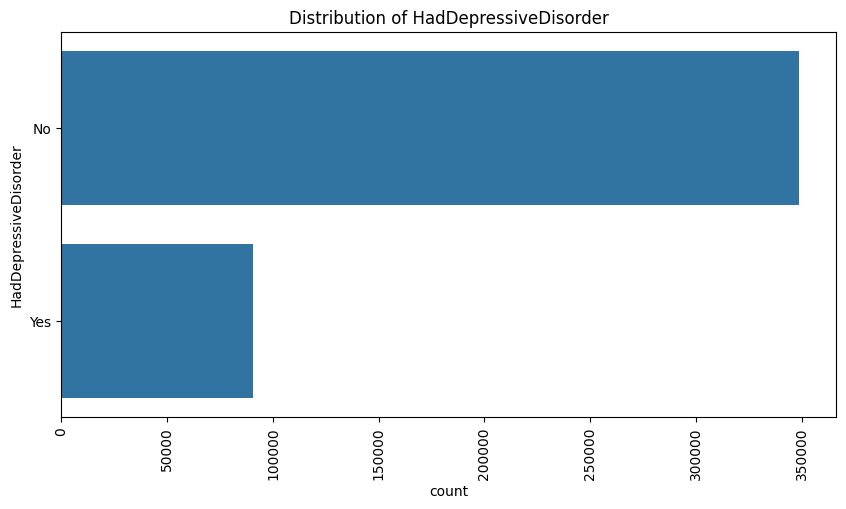

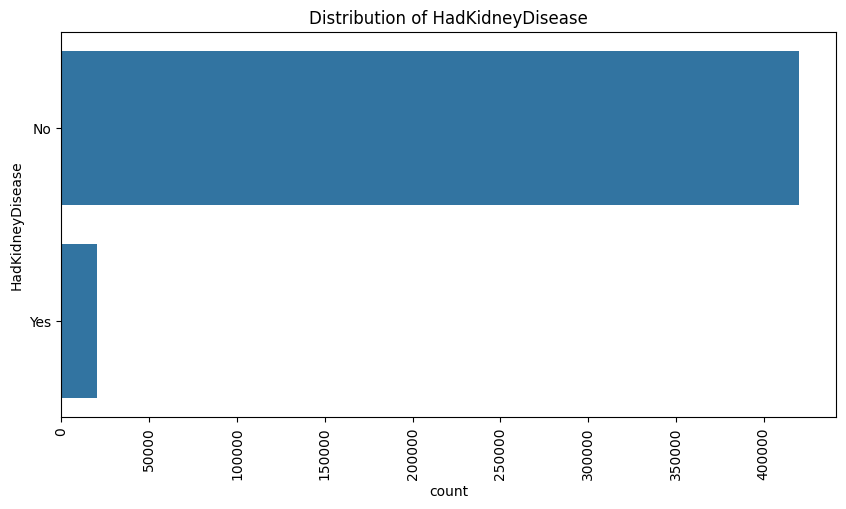

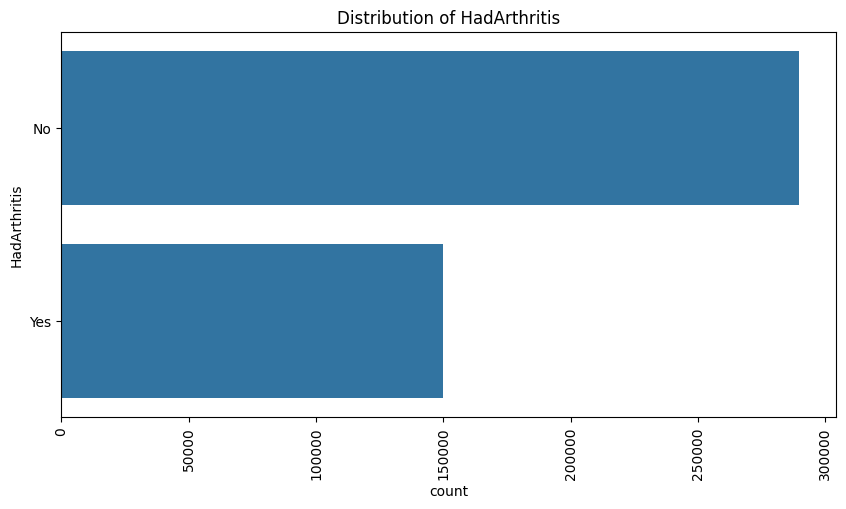

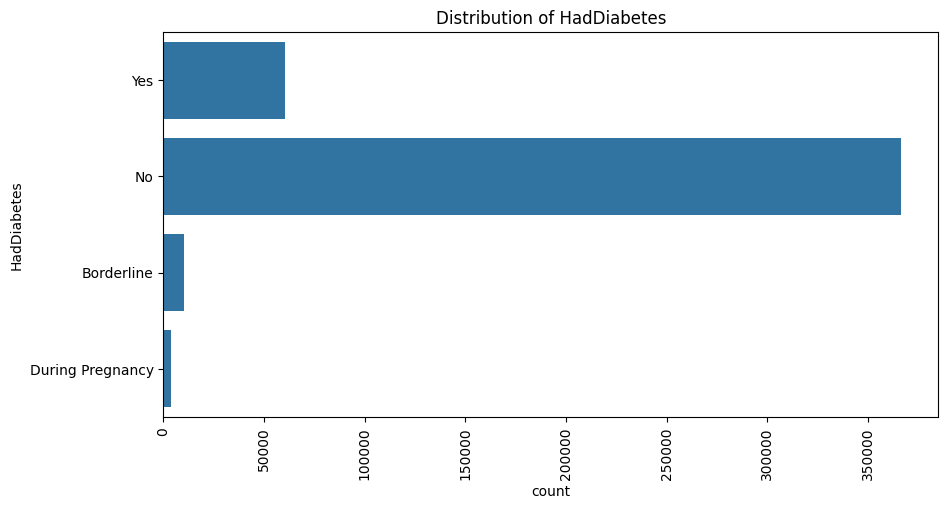

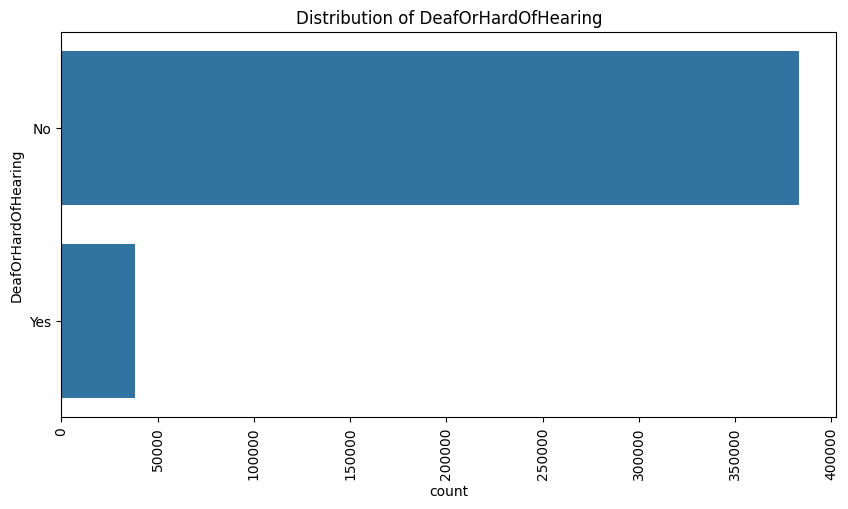

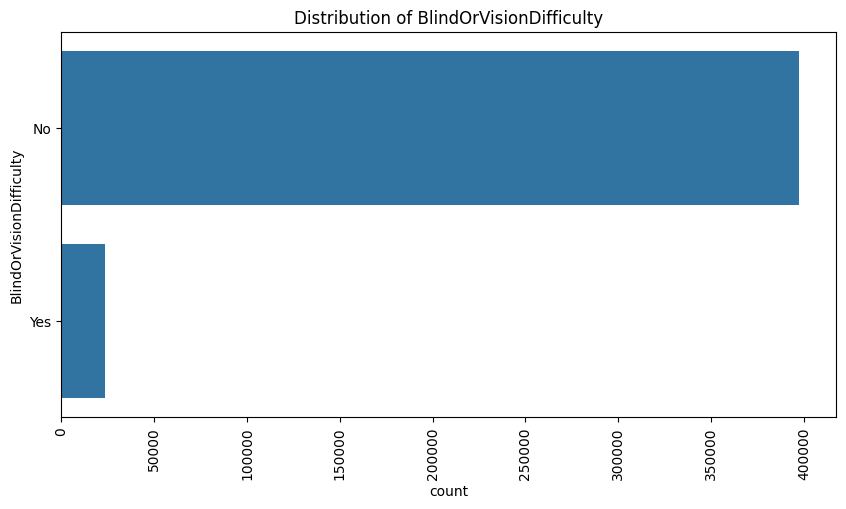

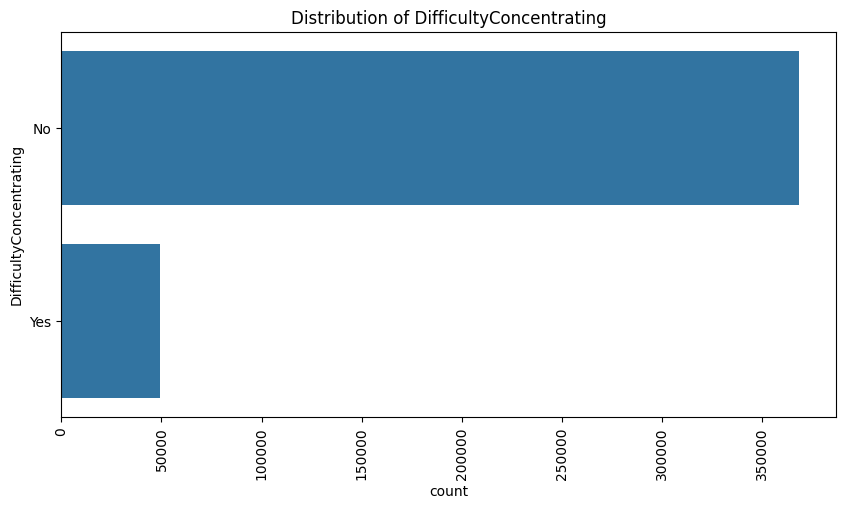

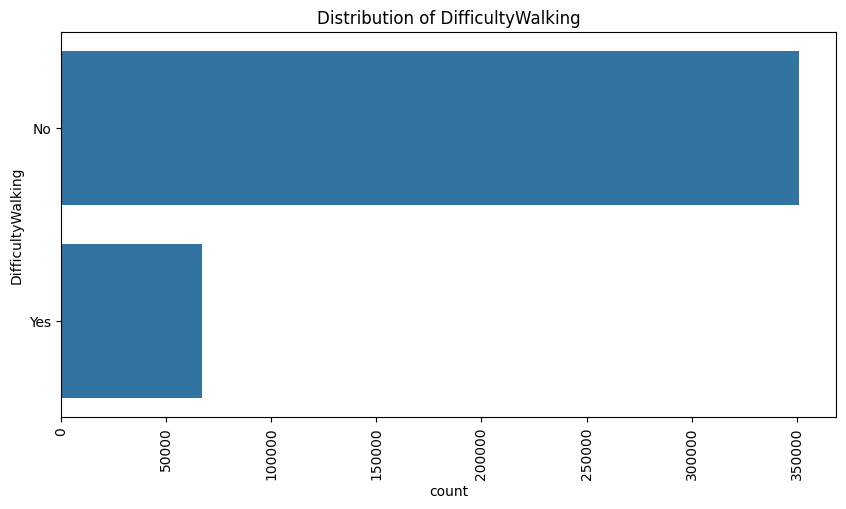

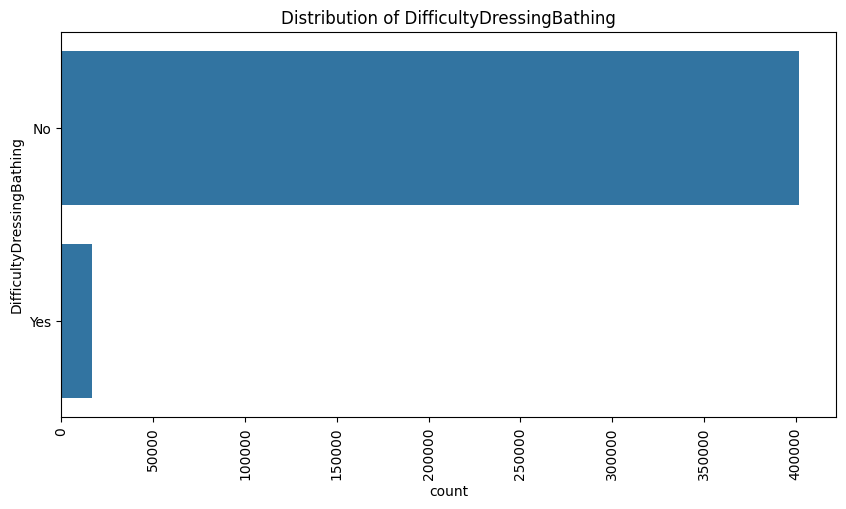

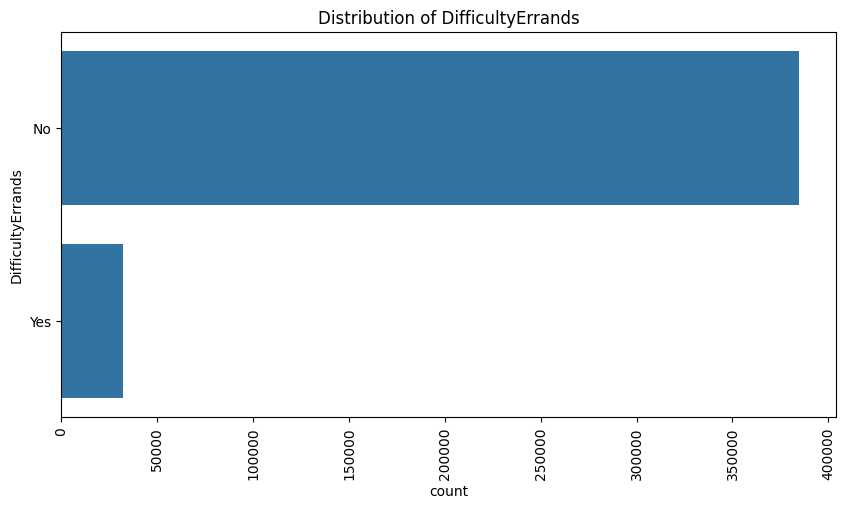

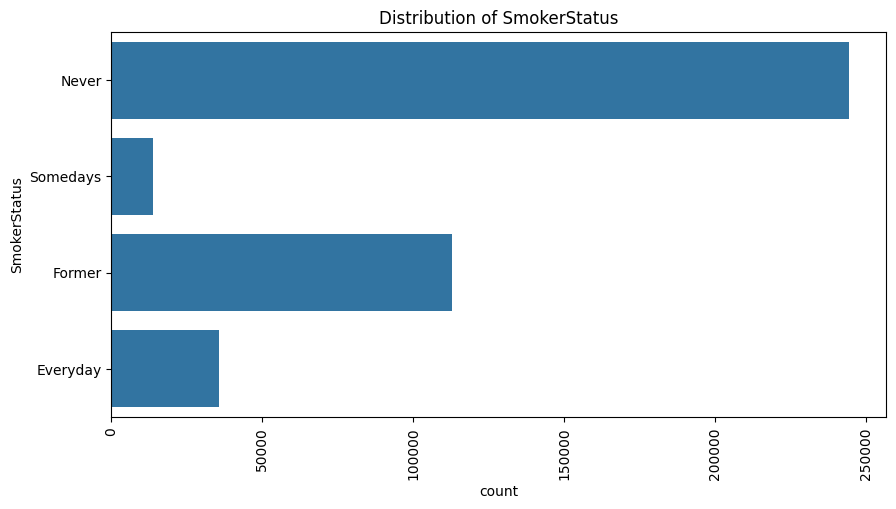

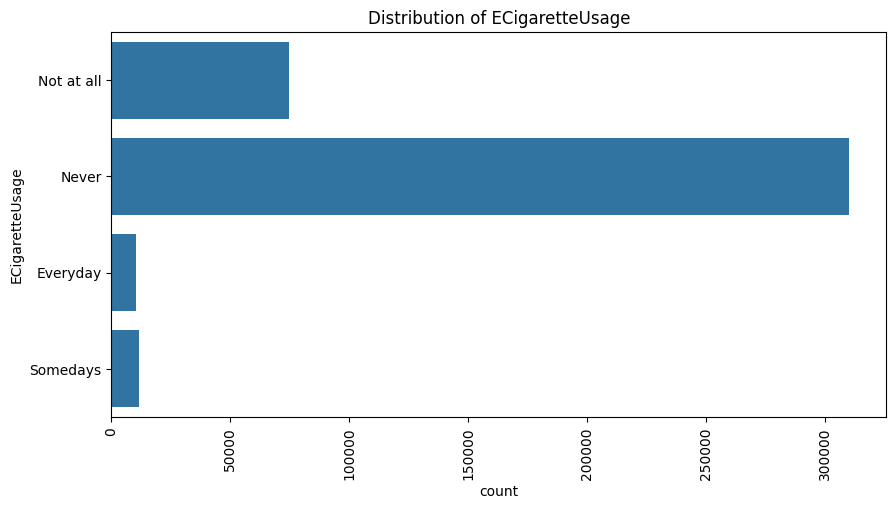

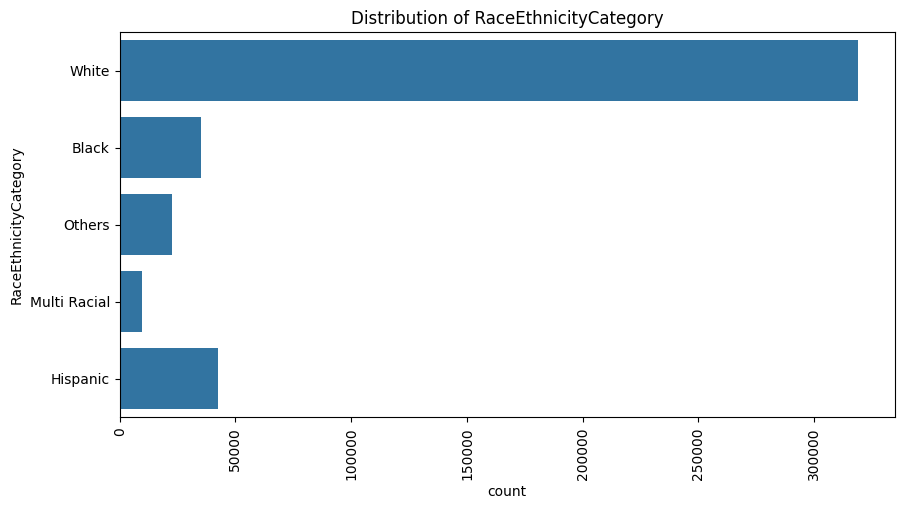

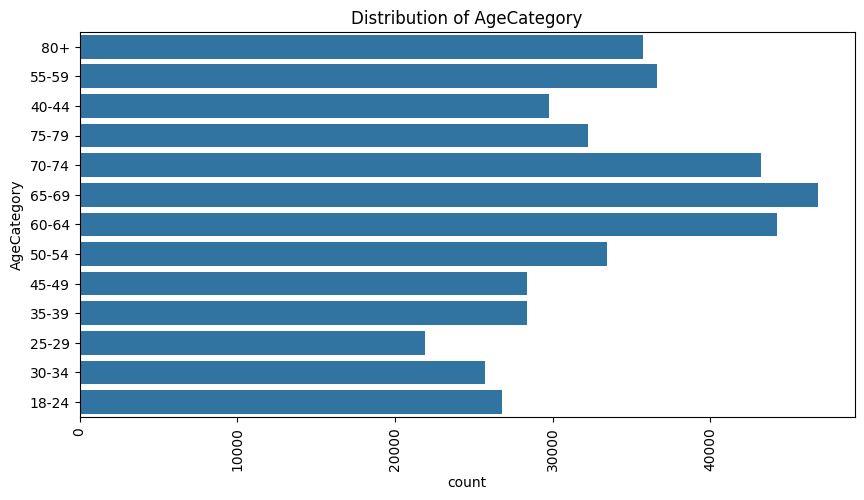

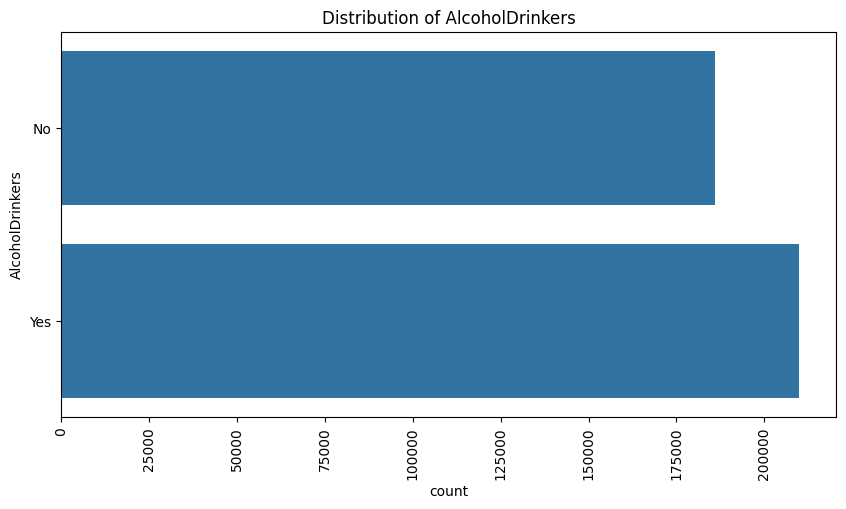

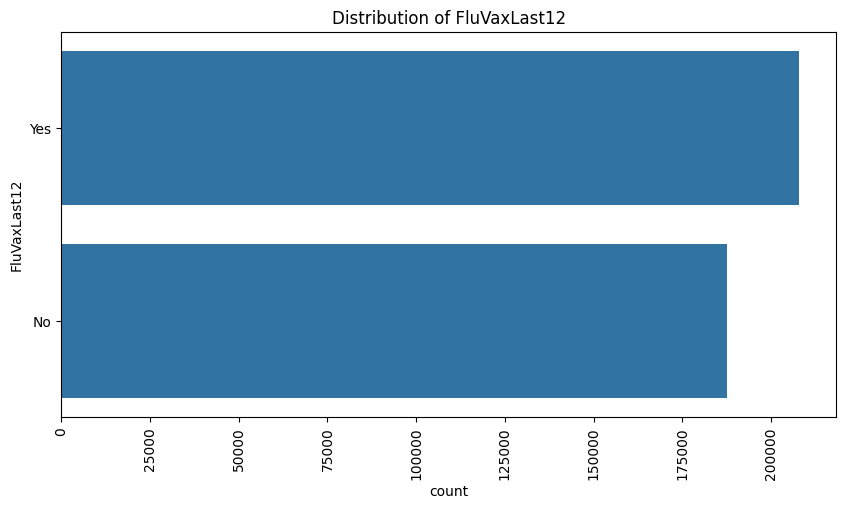

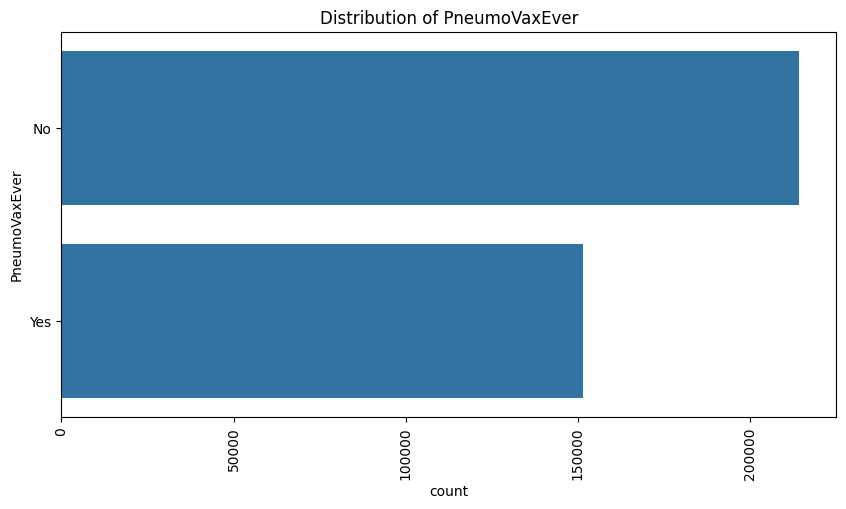

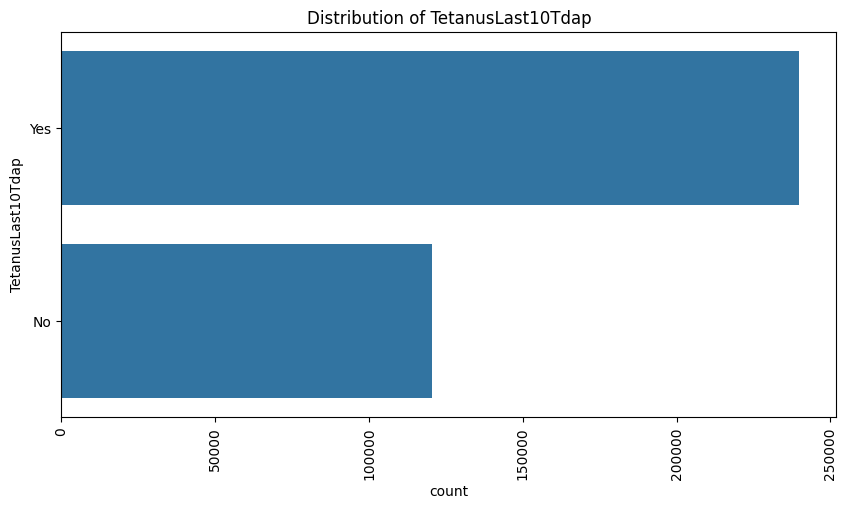

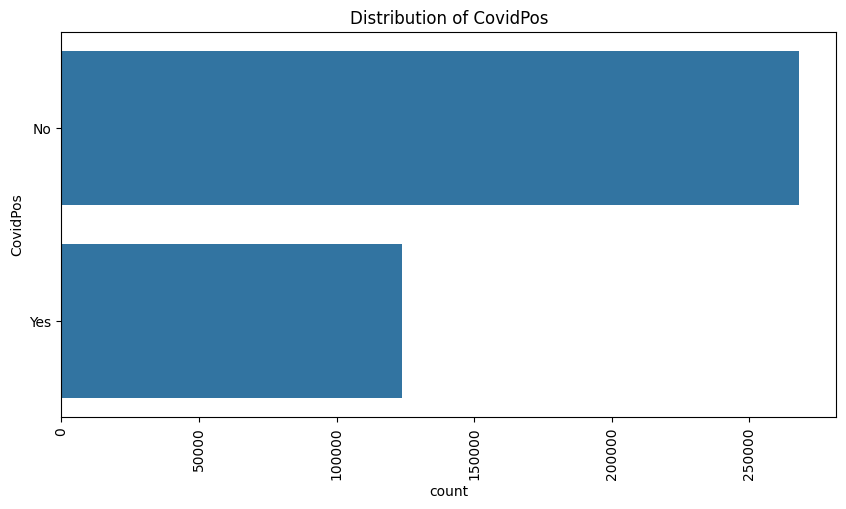

In [14]:
# Plot bar plots for categorical features
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(df[col])
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=90)
    plt.show()

### Handling Outliers

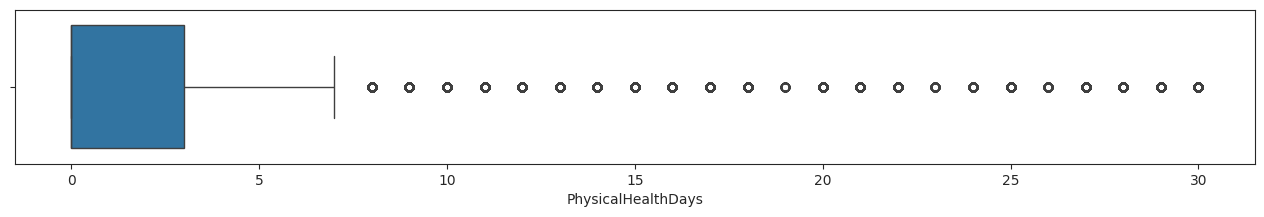

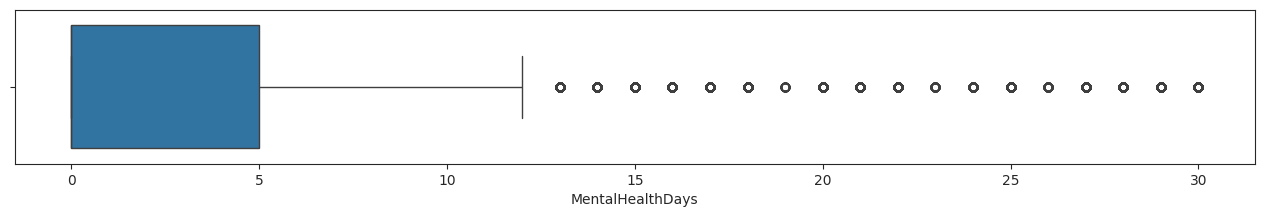

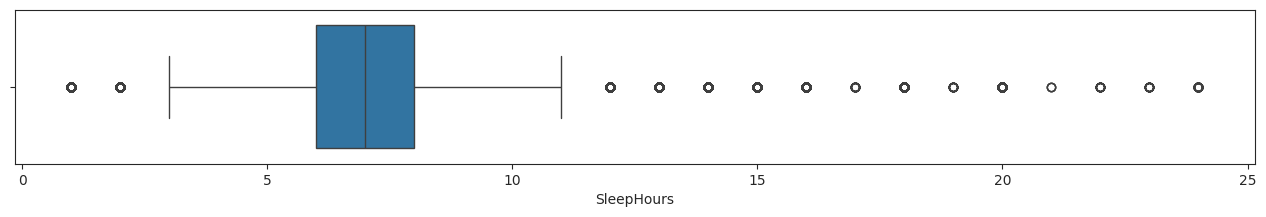

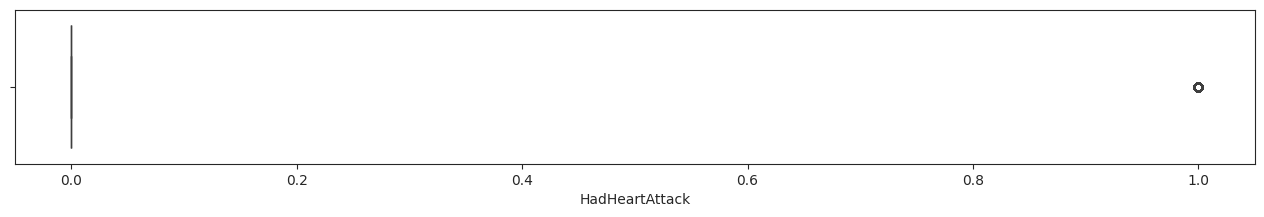

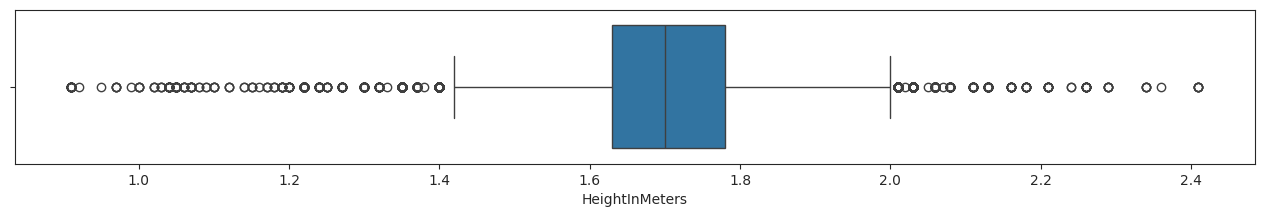

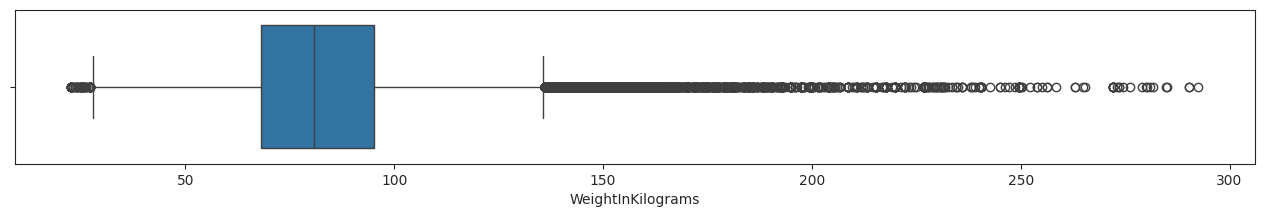

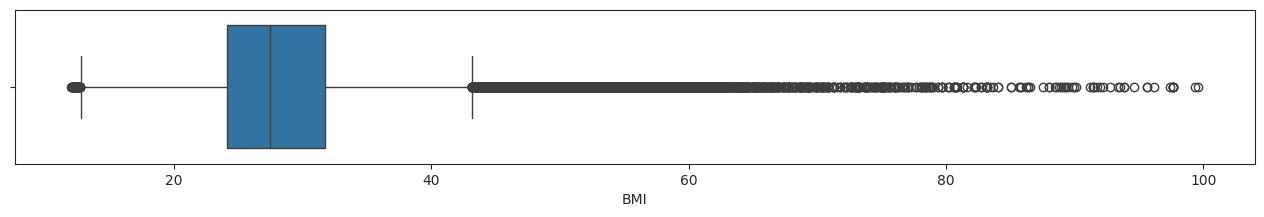

In [15]:
# Identify Outliers using box plots
for col in df.describe().columns:
    sns.set_style('ticks')
    plt.figure(figsize=(16, 2))
    sns.boxplot(data=df, x=col)
    plt.show()

<Axes: >

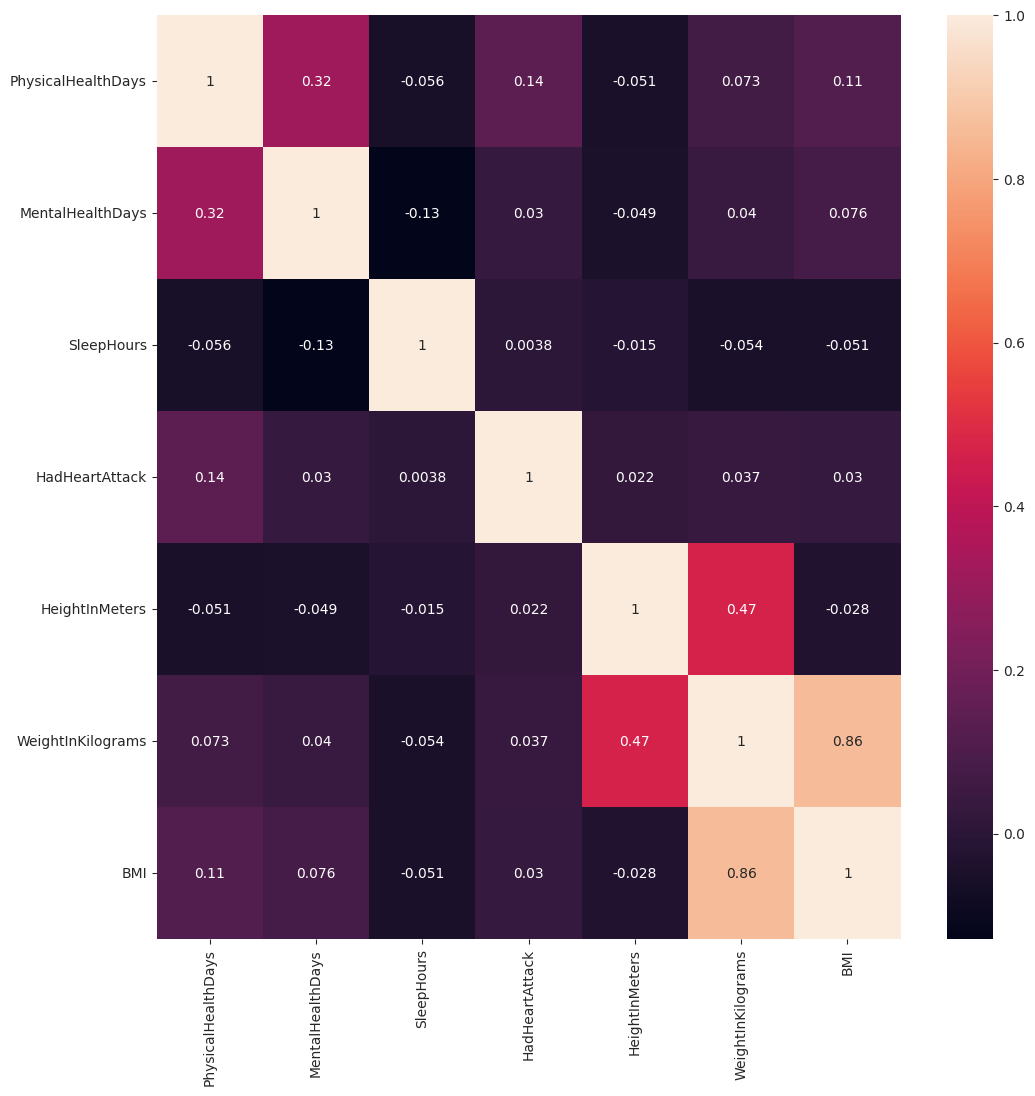

In [16]:
# Heatmap to identify to spot outliers
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [17]:
# Dropping 'WeightInKilograms' because the correlation with 'BMI' that may cause redundancy
df.drop('WeightInKilograms', inplace=True, axis=1)

In [18]:
# Extracting outliers in column of dataframe
def get_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3-Q1

    lower_limit = Q1 - (IQR * 1.5)
    upper_limit = Q3 + (IQR * 1.5)

    outliers = df[(df[column] < lower_limit) | (df[column] > upper_limit)]

    return outliers, lower_limit, upper_limit

In [19]:
# Define a function to get outliers and print limits
def print_outliers_and_limits(df, column):
    outliers, lower_limit, upper_limit = get_outliers(df, column)
    print(f"{column} Outliers:")
    print(f"Lower Limit: {lower_limit}")
    print(f"Upper Limit: {upper_limit}")
    print()

# Call the function for each variable
print_outliers_and_limits(df, 'BMI')
print_outliers_and_limits(df, 'PhysicalHealthDays')
print_outliers_and_limits(df, 'MentalHealthDays')
print_outliers_and_limits(df, 'SleepHours')


BMI Outliers:
Lower Limit: 12.715
Upper Limit: 43.155

PhysicalHealthDays Outliers:
Lower Limit: -4.5
Upper Limit: 7.5

MentalHealthDays Outliers:
Lower Limit: -7.5
Upper Limit: 12.5

SleepHours Outliers:
Lower Limit: 3.0
Upper Limit: 11.0



In [20]:
# Remove outliers for BMI
df = df.drop(df[(df['BMI'] < 12.7) | (df['BMI'] > 43.18)].index)

# Remove outliers for PhysicalHealthDays
df = df.drop(df[(df['PhysicalHealthDays'] < -4.5) | (df['PhysicalHealthDays'] > 7.5)].index)

# Remove outliers for MentalHealthDays
df = df.drop(df[(df['MentalHealthDays'] < -7.5) | (df['MentalHealthDays'] > 12.5)].index)

# Remove outliers for SleepHours
df = df.drop(df[(df['SleepHours'] < 3.0) | (df['SleepHours'] > 11.0)].index)

# Reset index after removing rows
df.reset_index(drop=True, inplace=True)

# Check the shape of the DataFrame after removing outliers
print(f"Shape of DataFrame after removing outliers: {df.shape}")

Shape of DataFrame after removing outliers: (324763, 33)


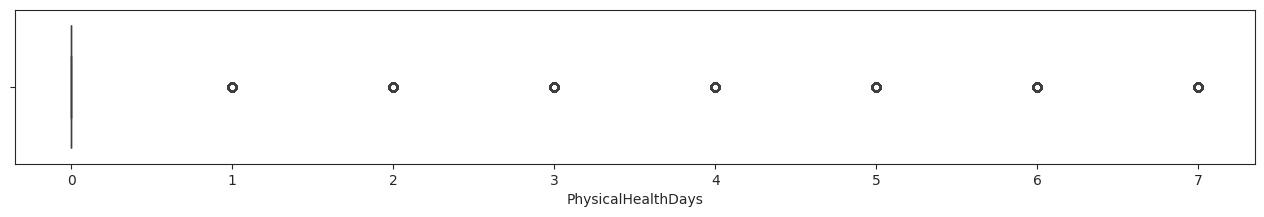

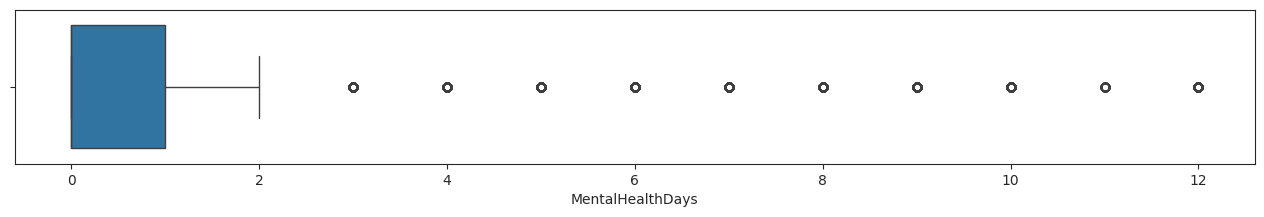

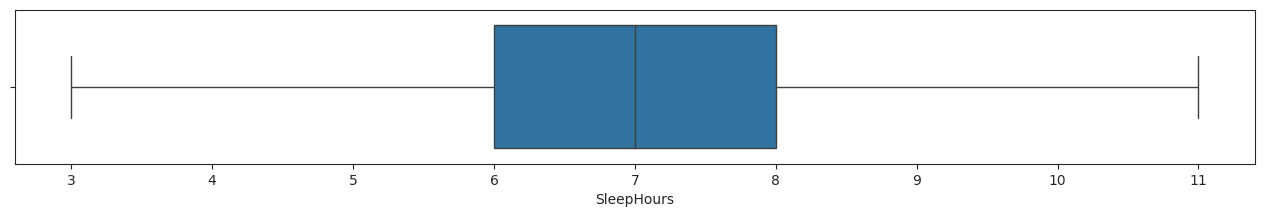

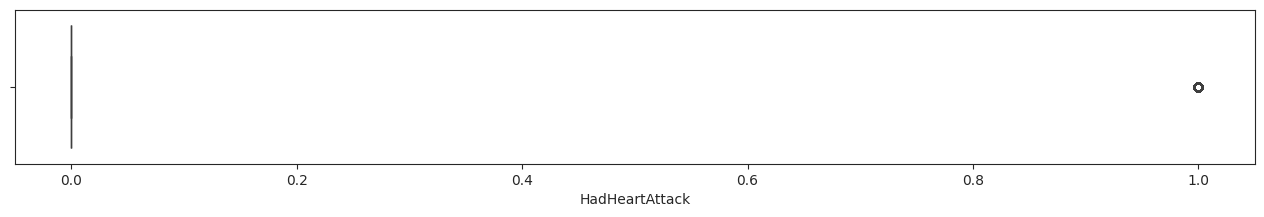

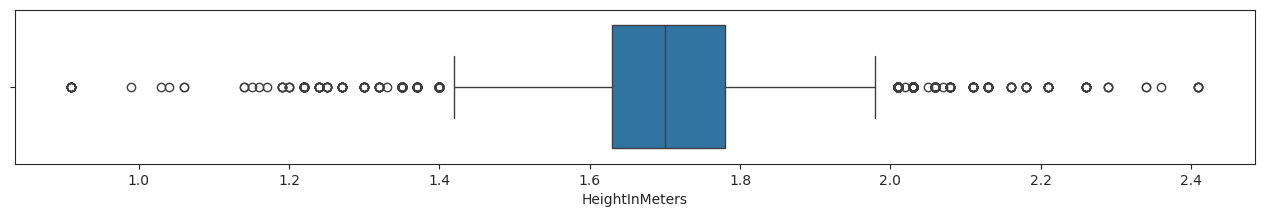

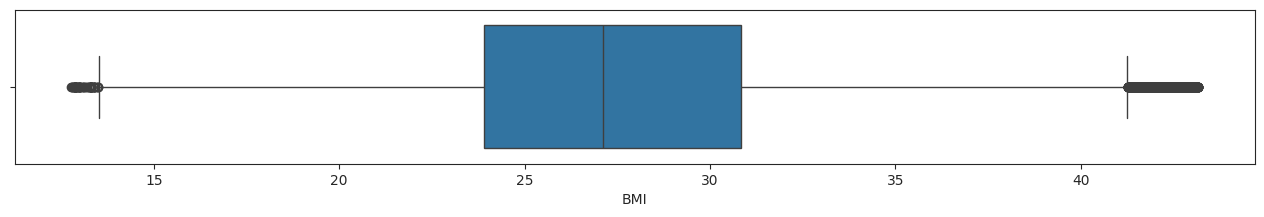

In [21]:
# Identify Outliers using box plots
for col in df.describe().columns:
    sns.set_style('ticks')
    plt.figure(figsize=(16, 2))
    sns.boxplot(data=df, x=col)
    plt.show()

### Handling Missing values


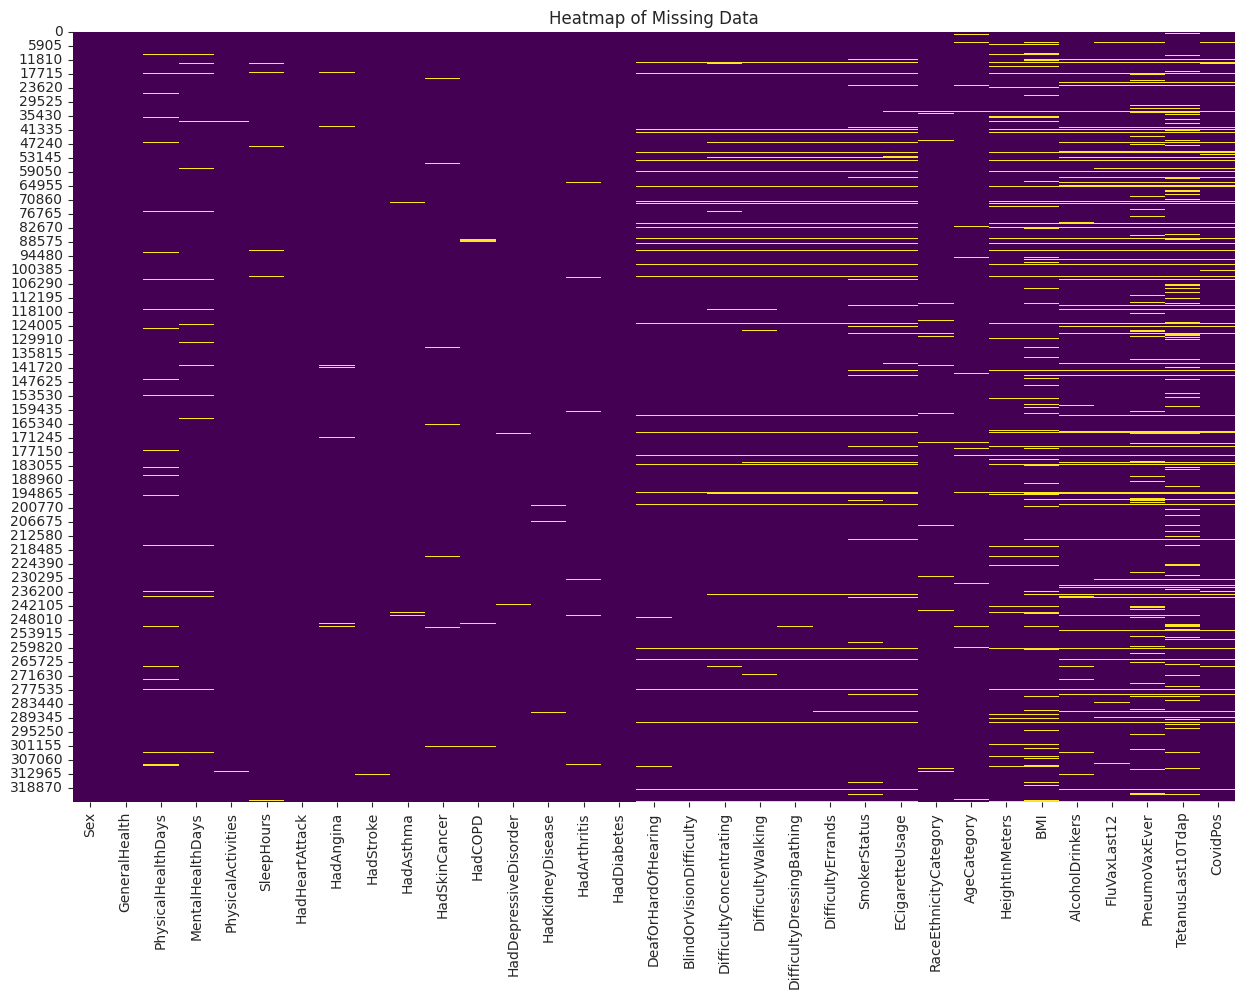

In [22]:
# Heatmap to dentify Missing Data
plt.figure(figsize=(15, 10))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Data')
plt.show()

In [23]:
# Count missing values
df.isnull().sum()

Sex                              0
GeneralHealth                  659
PhysicalHealthDays            8692
MentalHealthDays              6871
PhysicalActivities             640
SleepHours                    3375
HadHeartAttack                   0
HadAngina                     1993
HadStroke                      546
HadAsthma                      843
HadSkinCancer                 1769
HadCOPD                       1048
HadDepressiveDisorder         1312
HadKidneyDisease               919
HadArthritis                  1498
HadDiabetes                    512
DeafOrHardOfHearing          15555
BlindOrVisionDifficulty      16137
DifficultyConcentrating      17714
DifficultyWalking            17928
DifficultyDressingBathing    17928
DifficultyErrands            19056
SmokerStatus                 26535
ECigaretteUsage              26607
RaceEthnicityCategory         9930
AgeCategory                   6987
HeightInMeters               21954
BMI                          36971
AlcoholDrinkers     

In [24]:
# Impute missing values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
])

In [25]:
# Fit the preprocessor

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [26]:
# Convert the transformed data back to DataFrames
X_train = pd.DataFrame(X_train, columns=numeric_cols.tolist() +
                          preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols).tolist())

X_test = pd.DataFrame(X_test, columns=numeric_cols.tolist() +
                          preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols).tolist())

In [27]:
# Check missing values

print(X_train.isnull().sum())
print(X_test.isnull().sum())

PhysicalHealthDays       0
MentalHealthDays         0
SleepHours               0
HeightInMeters           0
WeightInKilograms        0
                        ..
PneumoVaxEver_Yes        0
TetanusLast10Tdap_No     0
TetanusLast10Tdap_Yes    0
CovidPos_No              0
CovidPos_Yes             0
Length: 83, dtype: int64
PhysicalHealthDays       0
MentalHealthDays         0
SleepHours               0
HeightInMeters           0
WeightInKilograms        0
                        ..
PneumoVaxEver_Yes        0
TetanusLast10Tdap_No     0
TetanusLast10Tdap_Yes    0
CovidPos_No              0
CovidPos_Yes             0
Length: 83, dtype: int64


# Handling Imbalanced Data


- Use Random Under Sampler

In [28]:
# Check target distribtuion
df['HadHeartAttack'].value_counts(normalize=True)

HadHeartAttack
0    0.955965
1    0.044035
Name: proportion, dtype: float64

In [29]:
# Apply RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_r, y_train_r = rus.fit_resample(X_train, y_train)
X_test_r, y_test_r = rus.fit_resample(X_test, y_test)


print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_train_r))

Original dataset shape Counter({0: 333547, 1: 20106})
Resample dataset shape Counter({0: 20106, 1: 20106})


# Model Selection

- Choose appropriate algorithms for the classification task (Logistic Regression, Decision Trees, Bagging, Random Forest).

- Hyperparameter tuning using GridSearchCV

In [43]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Bagged Trees': BaggingClassifier(),
    'Random Forest': RandomForestClassifier(),
}

# Dictionary to store results
results = {}

for name, model in models.items():
    # Fit the model
    model.fit(X_train_r, y_train_r)

    # Predict on the resampled training set
    train_pred = model.predict(X_train_r)
    train_f1 = f1_score(y_train_r, train_pred)

    # Predict on the resampled test set
    test_pred = model.predict(X_test_r)
    test_f1 = f1_score(y_test_r, test_pred)

    # Store results
    results[name] = {'Train F1': train_f1, 'Test F1': test_f1}

# Print the results
for model_name, scores in results.items():
    print(f"{model_name}: Train F1 = {scores['Train F1']:.3f}, Test F1 = {scores['Test F1']:.3f}")

# The `results` dictionary contains the F1 scores for each model on both the resampled training and test sets
results

Logistic Regression: Train F1 = 0.788, Test F1 = 0.787
Decision Tree: Train F1 = 1.000, Test F1 = 0.709
Bagged Trees: Train F1 = 0.985, Test F1 = 0.759
Random Forest: Train F1 = 1.000, Test F1 = 0.789


{'Logistic Regression': {'Train F1': 0.788010560646063,
  'Test F1': 0.7869465807524423},
 'Decision Tree': {'Train F1': 0.999676624959578,
  'Test F1': 0.7094248720264981},
 'Bagged Trees': {'Train F1': 0.9847427854454204,
  'Test F1': 0.7591862154868175},
 'Random Forest': {'Train F1': 0.9996517586189742,
  'Test F1': 0.7886952998379254}}

In [45]:
# Hyperparameter tuning using GridSearchCV
rf = RandomForestClassifier(random_state=42)

rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, scoring='f1')
gs.fit(X_train_r, y_train_r)

# Print the best score and parameters from GridSearchCV
print(f"Best Score from GridSearchCV: {gs.best_score_:.4f}")
print(f"Best Parameters from GridSearchCV: {gs.best_params_}")

Best Score from GridSearchCV: 0.7874
Best Parameters from GridSearchCV: {'max_depth': None, 'n_estimators': 200}


# Model Training & Evaluation

- Model chosen: **Random Forest**
  - Find best parameters for Random Forest
  - Train the Random Forest with the best parameters

- Evaluate the model using metrics such as accuracy, precision, recall, F1-score, ROC-AUC, and confusion matrix.

- Perform cross-validation to ensure consistent performance.

In [46]:
# Training the Random Forest with the best parameters
rf_best = RandomForestClassifier(n_estimators=gs.best_params_['n_estimators'],
                                 max_depth=gs.best_params_['max_depth'],
                                 random_state=42)

# Fit the model on the resampled training data
rf_best.fit(X_train_r, y_train_r)

# Make predictions on the resampled test data
y_pred_r = rf_best.predict(X_test_r)

# Evaluate the model
test_f1 = f1_score(y_test_r, y_pred_r)
test_accuracy = accuracy_score(y_test_r, y_pred_r)

print(f"Random Forest Model F1 Score on Test Data: {test_f1:.4f}")
print(f"Random Forest Model Accuracy on Test Data: {test_accuracy:.4f}")


Random Forest Model F1 Score on Test Data: 0.7882
Random Forest Model Accuracy on Test Data: 0.7917


In [47]:
# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test_r, y_pred_r)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test_r, y_pred_r))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_r, y_pred_r))

Accuracy: 0.7917

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.80      5002
           1       0.80      0.78      0.79      5002

    accuracy                           0.79     10004
   macro avg       0.79      0.79      0.79     10004
weighted avg       0.79      0.79      0.79     10004


Confusion Matrix:
[[4042  960]
 [1124 3878]]



ROC AUC: 0.8727


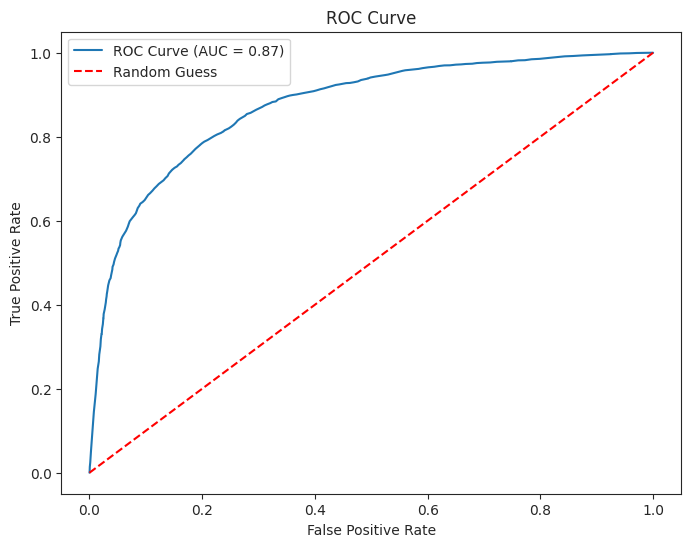

In [50]:
# Probabilities for positive class
y_probs = rf_best.predict_proba(X_test_r)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_r, y_probs)
roc_auc = auc(fpr, tpr)
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot ROC curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

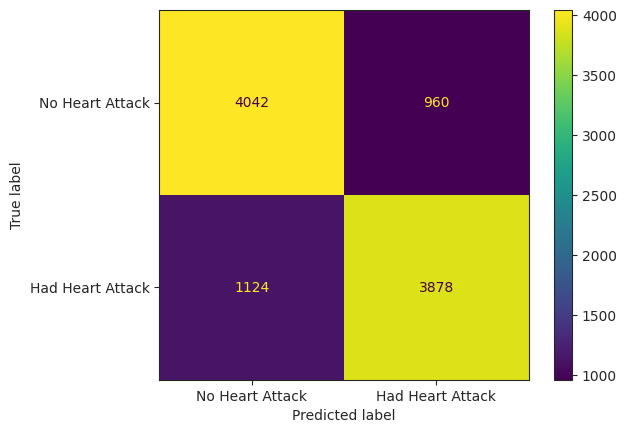

In [51]:
confusion_rf=confusion_matrix(y_test_r, y_pred_r)
cm_dis= ConfusionMatrixDisplay(confusion_rf, display_labels = ['No Heart Attack', 'Had Heart Attack'])
cm_dis.plot()

In [ ]:
# True Negatives (No Heart Attack): 4042
# False Positives (No Heart Attack but predicted as Had Heart Attack): 960
# False Negatives (Had Heart Attack but predicted as No Heart Attack): 1124
# True Positives (Had Heart Attack): 3878

In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# Predictions on the original test set
y_pred = rf_best.predict(X_test_r)

# Calculate various performance metrics
accuracy = accuracy_score(y_test_r, y_pred_r)
precision = precision_score(y_test_r, y_pred_r)
recall = recall_score(y_test_r, y_pred_r)
f1 = f1_score(y_test_r, y_pred_r)
roc_auc = roc_auc_score(y_test_r, rf_best.predict_proba(X_test_r)[:, 1])

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.7917
Precision: 0.8016
Recall: 0.7753
F1 Score: 0.7882
ROC AUC: 0.8727


In [54]:
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.9458112890591309

In [55]:
cross_val_score(rf, X_train_r, y_train_r, cv=5).mean()

0.7893166433850038